# Q2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

In [3]:
G = nx.read_edgelist("./Wiki-Vote.txt", create_using=nx.DiGraph, nodetype=int, comments="#", delimiter="\t")

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

try:
    hits_h, hits_a = nx.hits(G, max_iter=100)
except nx.PowerIterationFailedConvergence:
    print("HITS failed to converge, increasing iterations...")
    hits_h, hits_a = nx.hits(G, max_iter=1000)

pagerank = nx.pagerank(G, alpha=0.85)

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

df_scores = pd.DataFrame({
    'HITS_Authority': pd.Series(hits_a),
    'PageRank': pd.Series(pagerank),
    'In_Degree': pd.Series(in_degree),
    'Out_Degree': pd.Series(out_degree)
})

df_scores['Rank_HITS'] = df_scores['HITS_Authority'].rank(ascending=False)
df_scores['Rank_PR'] = df_scores['PageRank'].rank(ascending=False)

df_scores = df_scores.fillna(0)

print("Top 5 nodes by PageRank:")
print(df_scores.sort_values(by='Rank_PR').head())

Number of nodes: 7115
Number of edges: 103689
Top 5 nodes by PageRank:
      HITS_Authority  PageRank  In_Degree  Out_Degree  Rank_HITS  Rank_PR
4037        0.002573  0.004613        457          15        2.0      1.0
15          0.002202  0.003681        361          50        9.0      2.0
6634        0.001168  0.003525        203           3      111.0      3.0
2625        0.002198  0.003286        331           0       10.0      4.0
2398        0.002580  0.002605        340          62        1.0      5.0


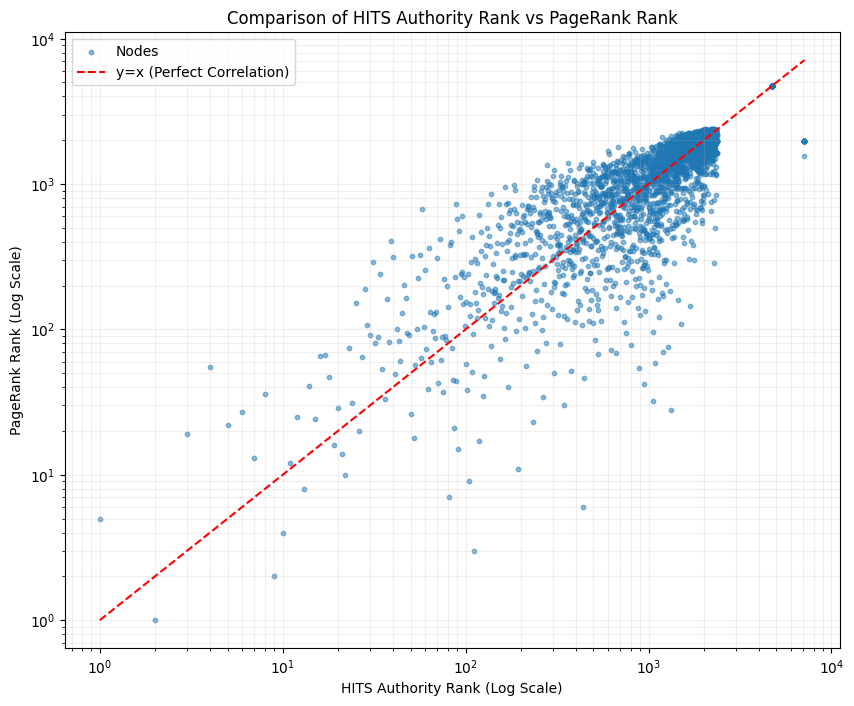

Top 10 Nodes by PageRank:
      HITS_Authority  PageRank  In_Degree  Out_Degree  Rank_HITS  Rank_PR
4037        0.002573  0.004613        457          15        2.0      1.0
15          0.002202  0.003681        361          50        9.0      2.0
6634        0.001168  0.003525        203           3      111.0      3.0
2625        0.002198  0.003286        331           0       10.0      4.0
2398        0.002580  0.002605        340          62        1.0      5.0
2470        0.000750  0.002530        149           0      439.0      6.0
2237        0.001252  0.002505        181         241       81.0      7.0
4191        0.002081  0.002266        259          20       13.0      8.0
7553        0.001187  0.002170        190           0      104.0      9.0
5254        0.001825  0.002150        265          33       22.0     10.0

Top 5 Anomalies (Highest Rank Divergence):
      HITS_Authority  PageRank  In_Degree  Out_Degree  Rank_HITS  Rank_PR
2470        0.000750  0.002530        149 

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(df_scores['Rank_HITS'], df_scores['Rank_PR'], alpha=0.5, s=10, label='Nodes')

max_rank = max(df_scores['Rank_HITS'].max(), df_scores['Rank_PR'].max())
plt.plot([1, max_rank], [1, max_rank], 'r--', label='y=x (Perfect Correlation)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('HITS Authority Rank (Log Scale)')
plt.ylabel('PageRank Rank (Log Scale)')
plt.title('Comparison of HITS Authority Rank vs PageRank Rank')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

top_10_pr = df_scores.sort_values(by='Rank_PR').head(10)

df_scores['Log_Rank_Diff'] = abs(np.log10(df_scores['Rank_HITS']) - np.log10(df_scores['Rank_PR']))
anomalies = df_scores.sort_values(by='Log_Rank_Diff', ascending=False).head(5)

print("Top 10 Nodes by PageRank:")
cols_to_show = ['HITS_Authority', 'PageRank', 'In_Degree', 'Out_Degree', 'Rank_HITS', 'Rank_PR']
print(top_10_pr[cols_to_show])

print("\nTop 5 Anomalies (Highest Rank Divergence):")
print(anomalies[cols_to_show])

nodes_to_track = list(top_10_pr.index) + list(anomalies.index)
nodes_to_track = list(set(nodes_to_track))

Running sensitivity analysis for 10 alpha values...


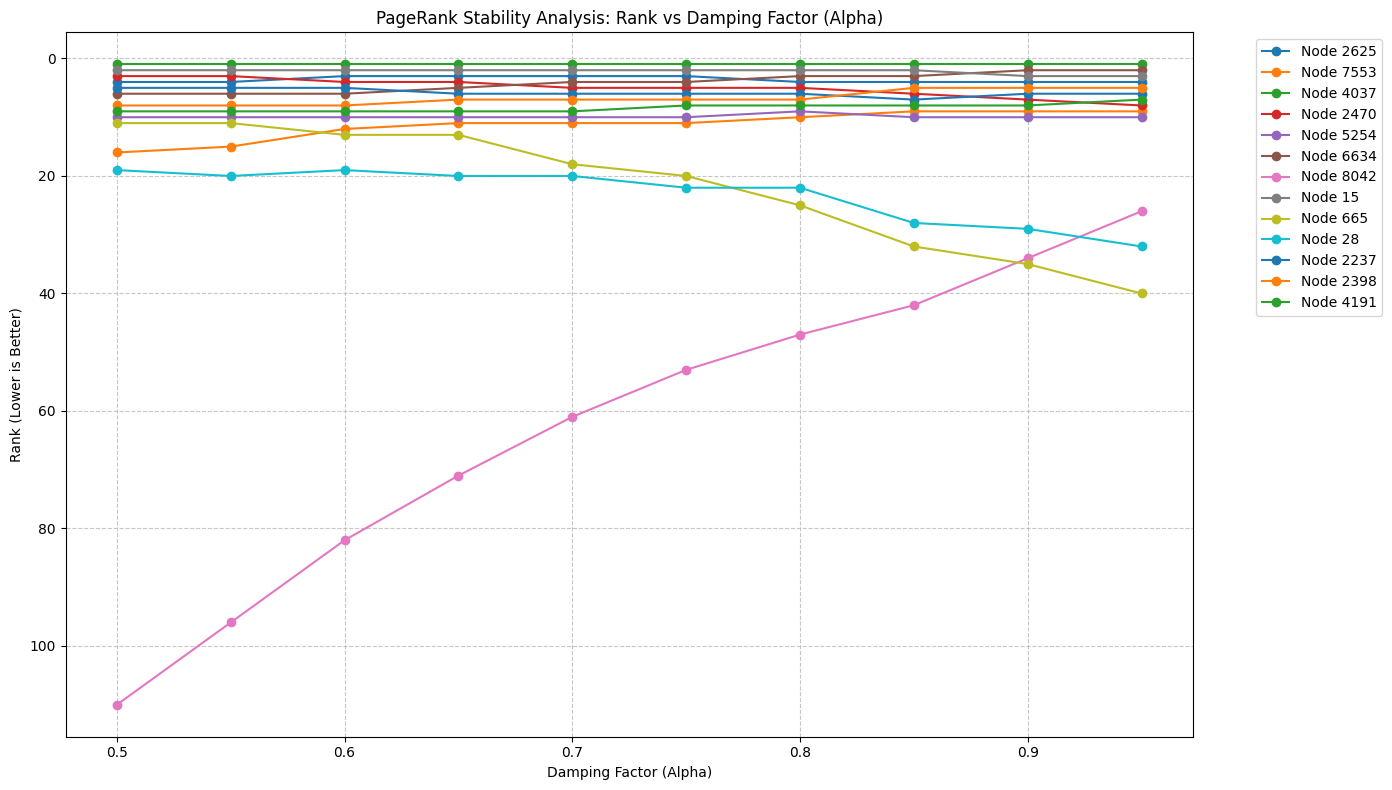

In [5]:
alphas = np.arange(0.50, 1.00, 0.05)

rank_history = {node: [] for node in nodes_to_track}

print(f"Running sensitivity analysis for {len(alphas)} alpha values...")

for alpha in alphas:
    pr_scores = nx.pagerank(G, alpha=alpha)

    s_scores = pd.Series(pr_scores)

    s_ranks = s_scores.rank(ascending=False, method='min')

    for node in nodes_to_track:
        rank_history[node].append(s_ranks.get(node))

plt.figure(figsize=(14, 8))

for node in nodes_to_track:
    plt.plot(alphas, rank_history[node], marker='o', label=f'Node {node}')

plt.title('PageRank Stability Analysis: Rank vs Damping Factor (Alpha)')
plt.xlabel('Damping Factor (Alpha)')
plt.ylabel('Rank (Lower is Better)')

plt.gca().invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()